# Usage of cdo_api_py

In [93]:
from cdo_api_py import Client
import pandas as pd
import datetime
from pprint import pprint
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import clear_output

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors
# Package to generate plot images
from src.frontend import plotter

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

def decompose_wind(df):
    # Convert degrees to radians
    
    radians_WDF2 = np.radians(df['WDF2'])
    radians_WDFG = np.radians(df['WDFG'])
    radians_WDF5 = np.radians(df['WDF5'])
    magnitude = df['AWND']
    
    df['WDF2_N'] = magnitude*np.cos(radians_WDF2)
    df['WDFG_N'] = magnitude*np.cos(radians_WDFG)
    df['WDF5_N'] = magnitude*np.cos(radians_WDF5)

    df['WDF2_E'] = magnitude*np.sin(radians_WDF2)
    df['WDFG_E'] = magnitude*np.sin(radians_WDFG)
    df['WDF5_E'] = magnitude*np.sin(radians_WDF5)
    
    df['AWND_N'] = df[['WDF2_N', 'WDFG_N', 'WDF5_N']].mean(axis=1)
    df['AWND_E'] = df[['WDF2_E', 'WDFG_E', 'WDF5_E']].mean(axis=1)
    
    df = df.drop(['WDF2_N', 'WDFG_N', 'WDF5_N', 'WDF2_E', 'WDFG_E', 'WDF5_E'], axis='columns')
    
    return df

def gaussian_interpolation(df, lon, lat, quantity, p=2):
    """
    Interpolate using Inverse Distance Weighting

    Parameters:
    - df: DataFrame with 'lon', 'lat', and 'PREC' columns
    - lon, lat: coordinates of the point to interpolate
    - p: power parameter for IDW

    Returns:
    - Interpolated value at (lon, lat)
    """
    df_temp = df.dropna(subset=quantity)
    # Calculate the distance matrix
    target = np.array([[lon, lat]])
    points = df_temp[['longitude', 'latitude']].values
    distances = distance_matrix(target, points).ravel()
    
    # Compute weights
    weights = np.exp(-distances**2/(2*p**2))
    weights /= weights.sum()

    # Compute interpolated value
    interpolated_value = np.dot(weights, df_temp[quantity].values)
    
    return interpolated_value

data_directory = '../data/flight/KJFK_KLAX/'
# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

compressor = compressors.CsvCompressor(config)

state_vector_file = os.path.join(data_directory, 'state_vectors', '758525_1673250271_1673269782_KJFK_KLAX.csv')

df = compressor.decode_to_dataframe_from_file(state_vector_file)

precision = 1000

distance_thresh = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=NEXRAD3&startdate=2023-01-09T01:44:31&enddate=2023-01-09T07:09:40&extent=33.25940115573943&extent=-123.18771739354659&extent=41.29581504940721&extent=-69.2910846403594&datatypeid=BREF1&limit=1000&units=metric


KeyError: 'longitude'

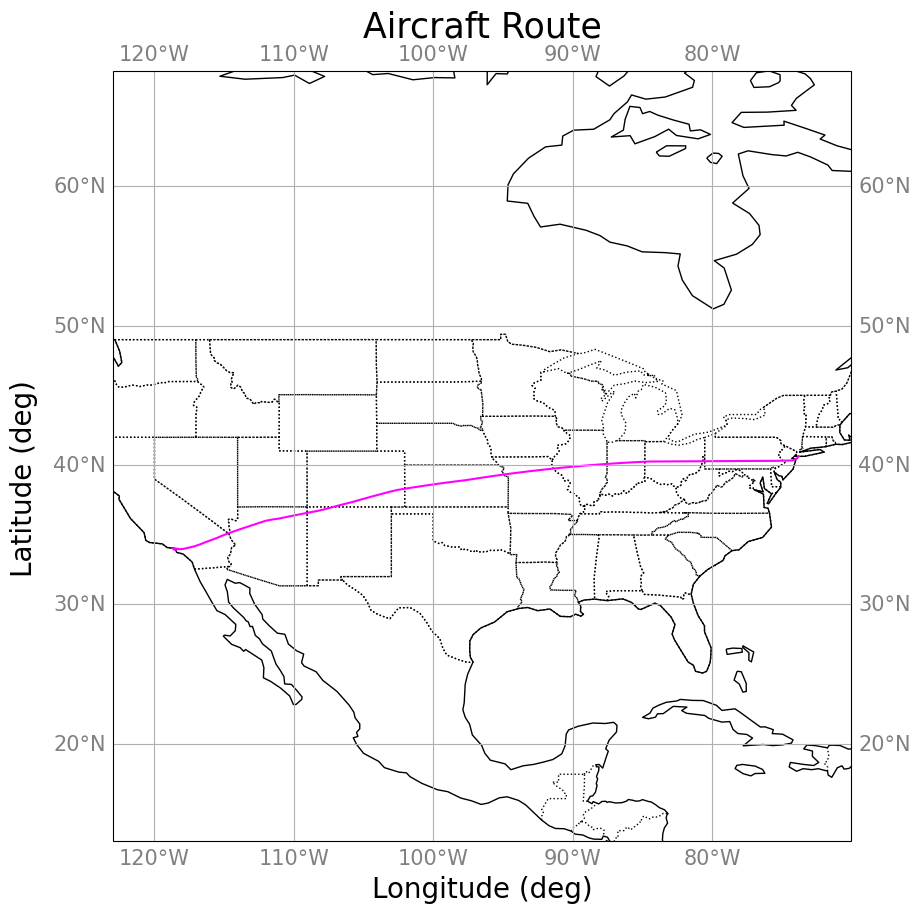

In [96]:
df_interp = {col:[] for col in ['time', 'lon', 'lat']}
df_interp = {'time':np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num=precision)}
for quantity in ['lon', 'lat']:
    df_interp[quantity] = np.interp(df_interp['time'], df['time'], df[quantity])
df = pd.DataFrame(df_interp)

min_lat = df['lat'].min()
max_lat = df['lat'].max()
min_lon = df['lon'].min()
max_lon = df['lon'].max()

range_lat = max_lat - min_lat
range_lon = max_lon - min_lon

min_lat = min_lat - 0.1*range_lat
max_lat = max_lat + 0.1*range_lat
min_lon = min_lon - 0.1*range_lon
max_lon = max_lon + 0.1*range_lon

token = "PLPiTIXLPtRaeDnEJZLqDYCsMapkwwmT" # be sure not to share your token publicly
my_client = Client(token, default_units='metric', default_limit=1000)
extent = {
"north": max_lat,
"south": min_lat,
"east": max_lon,
"west": min_lon,
}

startdate = datetime.datetime.fromtimestamp(df['time'].min())
enddate = datetime.datetime.fromtimestamp(df['time'].max())

datasetid='NEXRAD3'

datatypeid=['BREF1']

stations = my_client.find_stations(
    datasetid=datasetid,
    extent=extent,
    startdate=startdate,
    enddate=enddate,
    datatypeid=datatypeid,
    return_dataframe=True)

distances = np.zeros(len(stations))
for i, station in stations.iterrows():
    distances[i] = np.min(np.sqrt((station['longitude'] - df['lon'])**2 + 
                               (station['latitude'] - df['lat'])**2))
stations['distance_to_route'] = distances

colors = [plt.cm.viridis(d/max(distances)) for d in distances]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                               figsize=[10, 10])
pltr = plotter.Plotter(config)

pltr.plot_route(state_vector_file, compressor, ax = ax)
ax.scatter(stations['longitude'], stations['latitude'], color = colors)

x_min, x_max, y_min, y_max = ax.get_extent()
RANGE = np.max([y_max - y_min, x_max - x_min])
y_mid = (y_max + y_min)/2
x_mid = (x_max + x_min)/2
ax.set_extent([x_mid - RANGE/2, x_mid + RANGE/2, y_mid - RANGE/2, y_mid + RANGE/2])

fig.savefig('All_weather_stations_in_route.png')

(33.25940115573943, 41.29581504940721, -123.18771739354659, -69.2910846403594)

In [20]:
stations_data = None
count = 0
errors_found = 0
for rowid, station in stations.iterrows(): # remember this is a pandas dataframe!
    try:
        station_data = my_client.get_data_by_station(
        datasetid=datasetid,
        stationid=station['id'],
        startdate=startdate,
        enddate=enddate,
        return_dataframe=True,
        include_station_meta=True
        )
        if stations_data is None:
            stations_data = station_data.copy()
        else:
            stations_data = pd.concat([stations_data, station_data.copy()])
        count += 1
        
    except:
        print("----------Error on station: ", rowid, '----------')
        errors_found += 1
    clear_output(wait=True)
    print(f"Stations searched: {rowid+1} / {len(stations)}")
    print(f"Stations gathered: {count}")  
    print(f"Errors found: {errors_found}")  

stations_data = decompose_wind(stations_data)

stations_data

Stations searched: 484 / 484
Stations gathered: 467
Errors found: 17


,station,date,AWND,PRCP,TMAX,TMIN,WDF2,WSF2,WT01,elevation,...,ASTP,AWBT,RHAV,RHMN,RHMX,WT03,WT06,WT04,AWND_N,AWND_E
0,GHCND:USC00035189,2023-01-09T00:00:00,2.7,0.0,11.7,-0.5,160.0,6.3,1.0,72.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.537170,9.234544e-01
0,GHCND:USC00050109,2023-01-09T00:00:00,1.8,0.0,3.9,-6.1,NaN,NaN,NaN,1384.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,GHCND:USC00053005,2023-01-09T00:00:00,1.3,0.0,10.0,-3.9,NaN,NaN,NaN,1525.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158430,1.290310e+00
0,GHCND:USC00053261,2023-01-09T00:00:00,7.6,0.0,6.1,-5.6,NaN,NaN,NaN,2596.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,GHCND:USC00058690,2023-01-09T00:00:00,1.8,0.0,7.8,-3.3,NaN,NaN,NaN,2138.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.378880,-1.157018e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,GHCND:USW00094870,2023-01-09T00:00:00,4.6,0.0,6.7,-6.6,180.0,9.4,1.0,226.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.600000,5.633375e-16
0,GHCND:USW00094895,2023-01-09T00:00:00,4.0,0.0,6.1,-1.6,280.0,7.6,1.0,285.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.347296,-3.969616e+00
0,GHCND:USW00094949,2023-01-09T00:00:00,3.9,0.0,10.0,-1.6,290.0,7.6,NaN,591.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.641939,-3.521150e+00
0,GHCND:USW00094957,2023-01-09T00:00:00,3.4,0.0,12.2,-3.8,200.0,7.2,NaN,298.8,...,9797.0,11.0,73.0,48.0,89.0,NaN,NaN,NaN,-3.271651,-8.766361e-01


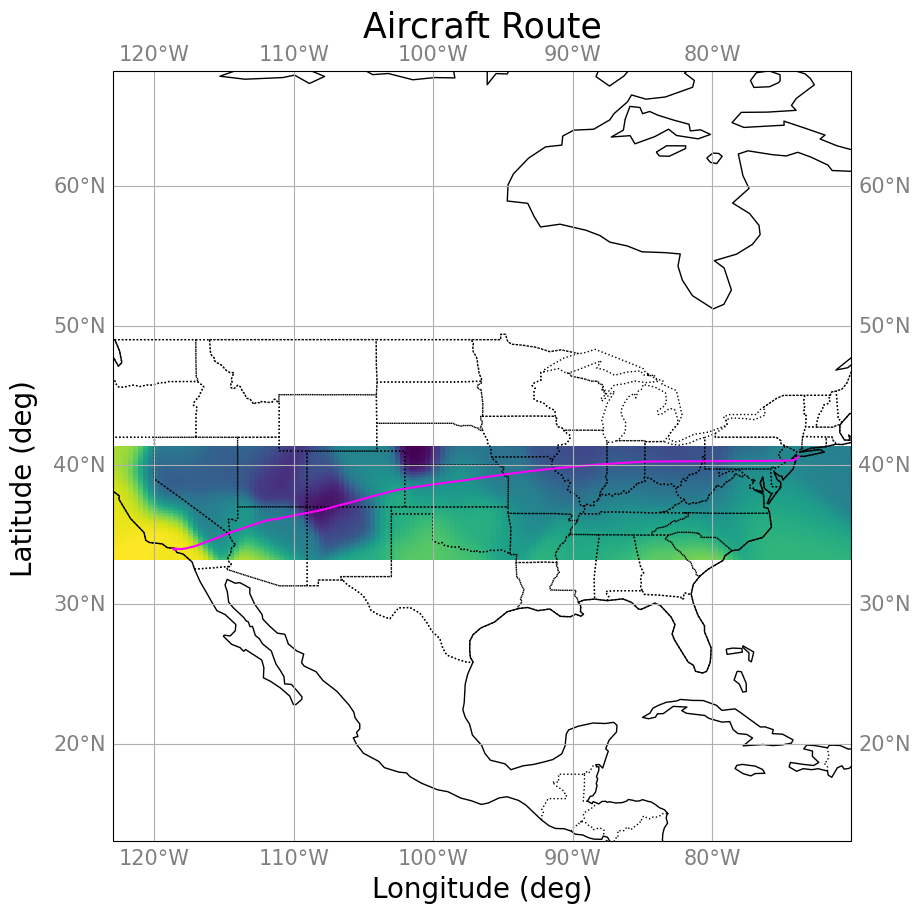

In [21]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix

# Test the function
xs = np.linspace(min_lon, max_lon, num = 150)
ys = np.linspace(min_lat, max_lat, num = 75)

p = 1
X, Y = np.meshgrid(xs, ys)
Z = [gaussian_interpolation(stations_data, x, y, 'TAVG', p=p) for x, y in zip(np.ravel(X), np.ravel(Y))]
Z = np.reshape(Z, X.shape)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                               figsize=[10, 10])
pltr = plotter.Plotter(config)

ax.pcolormesh(X, Y, Z)

pltr.plot_route(state_vector_file, compressor, ax = ax)

fig.savefig('TAVG_Estimate_in_route.png')

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix

xs = np.linspace(min_lon, max_lon, num = 50)
ys = np.linspace(min_lat, max_lat, num = 12)

X, Y = np.meshgrid(xs, ys)
xs = np.ravel(X)
ys = np.ravel(Y)

p = 1

zs_N = np.array([gaussian_interpolation(stations_data, x, y, 'AWND_N', p=p) for x, y in zip(xs, ys)])
zs_E = np.array([gaussian_interpolation(stations_data, x, y, 'AWND_E', p=p) for x, y in zip(xs, ys)])
zs = np.sqrt(zs_N**2 + zs_E**2)

norm = plt.Normalize(np.min(zs), np.max(zs))

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                               figsize=[10, 10])

quiv = ax.quiver(xs, ys, 2*zs_E/zs, 2*zs_N/zs, 
                 zs, angles='xy', scale_units='xy', scale=2, cmap='Reds', norm=norm)

pltr = plotter.Plotter(config)

pltr.plot_route(state_vector_file, compressor, ax = ax)

fig.savefig('AWND_Estimate_in_route.png')

# Reading NEXRAD Level III Files

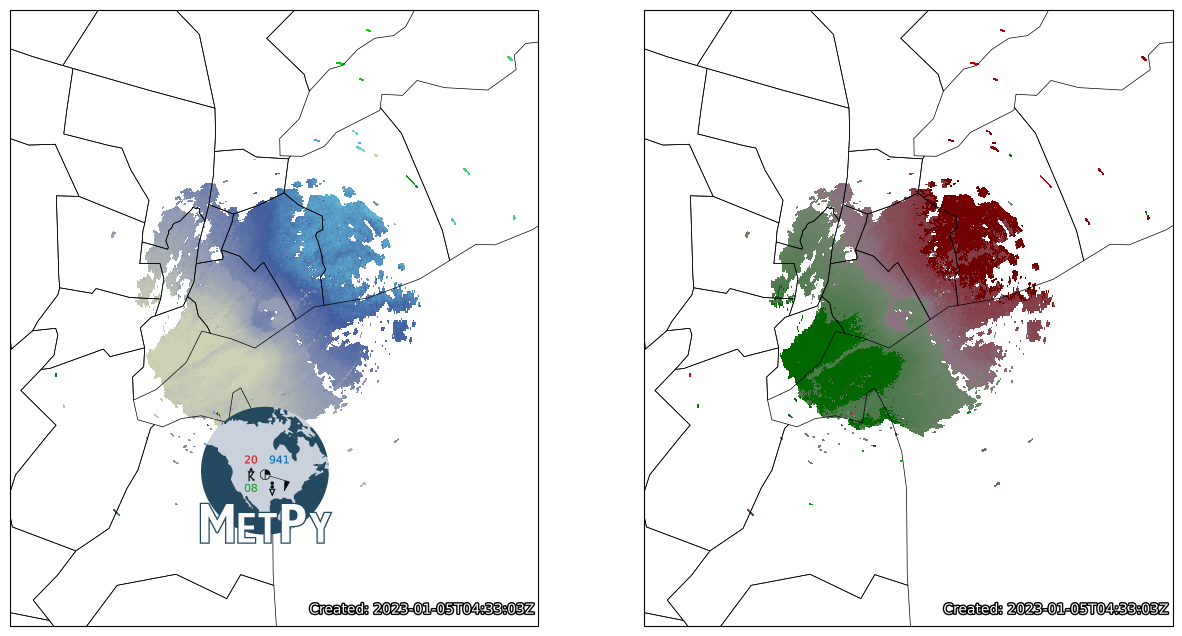

In [3]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from metpy.calc import azimuth_range_to_lat_lon
from metpy.cbook import get_test_data
from metpy.io import Level3File
from metpy.plots import add_metpy_logo, add_timestamp, colortables, USCOUNTIES
from metpy.units import units

spec = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(15, 8))
add_metpy_logo(fig, 190, 85, size='large')
ctables = (('NWSStormClearReflectivity', -20, 0.5),  # dBZ
           ('NWS8bitVel', -100, 1.0))  # m/s

for v, ctable, ax_rect in zip(('N0Q', 'N0U'), ctables, spec):
    # Open the file
    name = 'Weather_2023_01_01_2023_01_30_Level_III/KOKX_SDUS71_TV2JFK_202301050431'
    f = Level3File(name)

    # Pull the data out of the file object
    datadict = f.sym_block[0][0]

    # Turn into an array using the scale specified by the file
    data = f.map_data(datadict['data'])

    # Grab azimuths and calculate a range based on number of gates,
    # both with their respective units
    az = units.Quantity(np.array(datadict['start_az'] + [datadict['end_az'][-1]]), 'degrees')
    rng = units.Quantity(np.linspace(0, f.max_range, data.shape[-1] + 1), 'kilometers')

    # Extract central latitude and longitude from the file
    cent_lon = f.lon
    cent_lat = f.lat

    # Convert az,range to x,y
    xlocs, ylocs = azimuth_range_to_lat_lon(az, rng, cent_lon, cent_lat)

    # Plot the data
    crs = ccrs.LambertConformal()
    ax = fig.add_subplot(ax_rect, projection=crs)
    ax.add_feature(USCOUNTIES, linewidth=0.5)
    norm, cmap = colortables.get_with_steps(*ctable)
    ax.pcolormesh(xlocs, ylocs, data, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
    ax.set_extent([cent_lon - 0.5, cent_lon + 0.5, cent_lat - 0.5, cent_lat + 0.5])
    ax.set_aspect('equal', 'datalim')
    add_timestamp(ax, f.metadata['prod_time'], y=0.02, high_contrast=True)

plt.show()

In [10]:
# Getting info for all stations
import requests
from IPython.display import clear_output
import pandas as pd
import time

headers = {
    "token": "PLPiTIXLPtRaeDnEJZLqDYCsMapkwwmT"
}

url = "https://www.ncei.noaa.gov/cdo-web/api/v2/stations"
offset = 1
chunk_size = 1000
all_stations = []
error_count = 0
max_count = 149411

while True:
    try:
        response = requests.get(f"{url}?limit={chunk_size}&offset={offset}", headers=headers)
        
        # Check if the request was successful
        response.raise_for_status()
        
        data = response.json()
        
        # Append results to the list
        all_stations.extend(data['results'])
        
        # Check if there's more data to fetch
        if len(data['results']) < chunk_size:
            break  # No more data to be fetched
        
        # Update the offset
        offset += chunk_size
        
        # Clear the output and update the status
        clear_output(wait=True)
        print(f'Stations Found: {len(all_stations)} / {max_count}')

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")
        error_count += 1
    except requests.exceptions.ConnectionError as e:
        print(f"Connection error occurred: {e}")
        error_count += 1
    except requests.exceptions.Timeout as e:
        print(f"Timeout error occurred: {e}")
        error_count += 1
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        error_count += 1

    # If any kind of exception occurs, wait for 10 seconds before the next attempt
    if error_count > 0:
        time.sleep(10)  # Pausing execution for 10 seconds
        error_count = 0  # Resetting the error count

# Create a DataFrame from the collected data
stations = pd.DataFrame(all_stations)


Stations Found: 149000 / 149411


In [27]:
import requests

headers = {
    "token": "PLPiTIXLPtRaeDnEJZLqDYCsMapkwwmT"
}

url = "https://www.ncei.noaa.gov/cdo-web/api/v2/datasets"
offset = 1
chunk_size = 100 # Maximum number of responses expected in each loop. Keep it manageble
all_datasets = []

while True:
    response = requests.get(f"{url}?limit={chunk_size}&offset={offset}", headers=headers)
    data = response.json()
    
    # Append results to the list
    all_datasets.extend(data['results'])
    
    # Check if there's more data to fetch
    if len(data['results']) < chunk_size:
        break
    
    # Update the offset
    offset += chunk_size

dsts_df =  pd.DataFrame(all_datasets).set_index('id')
dsts_df

,uid,mindate,maxdate,name,datacoverage
id,,,,,
GHCND,gov.noaa.ncdc:C00861,1763-01-01,2023-10-21,Daily Summaries,1.00
GSOM,gov.noaa.ncdc:C00946,1763-01-01,2023-10-01,Global Summary of the Month,1.00
GSOY,gov.noaa.ncdc:C00947,1763-01-01,2023-01-01,Global Summary of the Year,1.00
NEXRAD2,gov.noaa.ncdc:C00345,1991-06-05,2023-10-23,Weather Radar (Level II),0.95
NEXRAD3,gov.noaa.ncdc:C00708,1994-05-20,2023-10-21,Weather Radar (Level III),0.95
NORMAL_ANN,gov.noaa.ncdc:C00821,2010-01-01,2010-01-01,Normals Annual/Seasonal,1.00
NORMAL_DLY,gov.noaa.ncdc:C00823,2010-01-01,2010-12-31,Normals Daily,1.00
NORMAL_HLY,gov.noaa.ncdc:C00824,2010-01-01,2010-12-31,Normals Hourly,1.00
NORMAL_MLY,gov.noaa.ncdc:C00822,2010-01-01,2010-12-01,Normals Monthly,1.00


# Downloading weather data with Siphon and pydap from Thredds database (or something)

Amazing manual, needed adjustment: https://notebook.community/rsignell-usgs/notebook/NEXRAD/THREDDS_NEXRAD-Copy1

Enconding information for NEXRAD2 data: https://www.ncei.noaa.gov/pub/data/radar/Radar-Decoding-EasySolution.txt

More info:

### Reflectivity Variables
Reflectivity data from radar is used to determine precipitation rates, types, and more.

1. **Reflectivity_HI**: High-resolution reflectivity data, usually more detailed and sensitive for identifying precipitation characteristics.
2. **Reflectivity**: Standard resolution reflectivity data, used for general observations of precipitation intensity.

### Radial Velocity Variables
Radial velocity measurements help in determining the motion of precipitation towards or away from the radar.

1. **RadialVelocity_HI**: High-resolution radial velocity data, providing detailed insights into precipitation dynamics.
2. **RadialVelocity**: Typical resolution data for radial velocity, indicating the speed and direction of precipitation relative to the radar position.

### Spectrum Width Variables
Spectrum width data is related to the variability of the radial velocity within a volume of air, indicative of turbulence.

1. **SpectrumWidth_HI**: High-resolution spectrum width data, critical for detailed turbulence analysis.
2. **SpectrumWidth**: Standard resolution spectrum width data, used for analyzing the variability or dispersion of velocities within a radar sample volume.

### Differential Reflectivity Variables
Differential reflectivity is utilized in discrimination between precipitation types (e.g., rain, snow, hail).

1. **DifferentialReflectivity_HI**: High-resolution differential reflectivity data, offering finer detail in precipitation type discrimination.
2. **DifferentialReflectivity**: Standard resolution differential reflectivity data, used for broader categorization of precipitation types.

### Correlation Coefficient Variables
The correlation coefficient is a measure of the similarity of the returned horizontal and vertical power returns, useful for identifying mixed precipitation and non-meteorological echoes.

1. **CorrelationCoefficient_HI**: High-resolution correlation coefficient data, essential for detailed analysis of precipitation heterogeneity.
2. **CorrelationCoefficient**: Standard resolution correlation coefficient data, for general assessments of radar returns' uniformity.

### Differential Phase Variables
Differential phase data pertains to the phase shift between horizontal and vertical pulses, related to precipitation types and sizes.

1. **DifferentialPhase_HI**: High-resolution differential phase data, key in detailed phase shift analysis for precipitation characterization.
2. **DifferentialPhase**: Standard resolution differential phase data, used for broader interpretations of precipitation properties.

### Common Descriptor Variables
These variables represent common dimensions or descriptors for radar data across different data types.

- **time**, **timeR**, **timeV**, **timeD**, **timeC**, **timeP**, **timeR_HI**, **timeV_HI**, **timeD_HI**, **timeC_HI**, **timeP_HI**: Timestamps for the corresponding data type's observations, marking the exact times at which observations were recorded.
- **elevation**, **elevationR**, **elevationV**, **elevationD**, **elevationC**, **elevationP**, **elevationR_HI**, **elevationV_HI**, **elevationD_HI**, **elevationC_HI**, **elevationP_HI**: Elevation angles at which the radar beam was directed for observations, impacting the vertical sampling of atmosphere.
- **azimuth**, **azimuthR**, **azimuthV**, **azimuthD**, **azimuthC**, **azimuthP**, **azimuthR_HI**, **azimuthV_HI**, **azimuthD_HI**, **azimuthC_HI**, **azimuthP_HI**: Azimuth angles from the radar, indicating the horizontal direction of the radar beam during each sweep.
- **distance**, **distanceR**, **distanceV**, **distanceD**, **distanceC**, **distanceP**, **distanceR_HI**, **distanceV_HI**, **distanceD_HI**, **distanceC_HI**, **distanceP_HI**: Radial distance from the radar to the atmospheric target or backscattered signal.
- **numRadials**, **numRadialsR**, **numRadialsV**, **numRadialsD**, **numRadialsC**, **numRadialsP**, **numRadialsR_HI**, **numRadialsV_HI**, **numRadialsD_HI**, **numRadialsC_HI**, **numRadialsP_HI**: Number of radial lines within a single sweep, or complete 360-degree scan by the radar.
- **numGates**, **numGatesR**, **numGatesV**, **numGatesD**, **numGatesC**, **numGatesP**, **numGatesR_HI**, **numGatesV_HI**, **numGatesD_HI**, **numGatesC_HI**, **numGatesP_HI**: Number of range gates (discrete data points) along each radial line, at which radar energy is received and processed.


### Interpreting Radial Velocity Data

Radial velocity data, particularly from the `RadialVelocity_HI` and `RadialVelocity` variables, require special handling and interpretation. These data types are stored in a compact byte format within the dataset and need to be converted to actual velocity measurements using the provided scale factor and offset. Here's how you handle these data:

**Attributes and Special Values:**
- **Units:** Radial velocities are recorded in meters per second (m/s).
- **Missing Data Indicators:** Specific byte values (e.g., 1 or 0) are designated as 'missing' or 'below detectable levels' in the raw data.
- **Scale Factor and Offset for Conversion:** The actual radial velocity values are derived from the raw data using the formula: `actual_value = (raw_value * scale_factor) + add_offset`. This adjustment is necessary due to the way the data are stored.
  - `scale_factor`: 0.5
  - `add_offset`: -64.5
- **Unsigned Data:** The data type for the radial velocities is unsigned byte, meaning raw values are non-negative integers. The offset is critical in adjusting these values to represent the actual velocities, which may be negative (motion toward the radar) or positive (motion away from the radar).
- **Range Folding Threshold:** Indicates a velocity magnitude beyond which the system cannot determine whether the motion is toward or away from the radar, necessitating special interpretation.

**Procedure for Data Conversion:**
To convert the byte values in the `RadialVelocity_HI` or `RadialVelocity` arrays to actual radial velocities, apply the scale factor and offset to each byte in the array, remembering to handle missing or below-threshold values appropriately. This process will translate the compacted byte information into meaningful meteorological data, representing the motion of precipitation particles as detected by the radar system.

**Example:**
```python
def convert_radial_velocity(raw_values, scale_factor=0.5, add_offset=-64.5):
    # Handling special values: You could choose to convert 'missing' or 'below threshold' indicators to NaN or some other indicator in this step.
    # Conversion to actual values
    actual_values = (raw_values * scale_factor) + add_offset
    return actual_values
```

This formula and the special value indicators are essential in ensuring that your data represents accurate atmospheric conditions and allows for correct meteorological interpretations and analyses.

In [71]:
import matplotlib
import warnings
from siphon.cdmr import Dataset
import os
import datetime
# warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)
%matplotlib inline

# The archive of data on S3 URL did not work for me, despite .edu domain
# url = 'http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/'

#Trying motherlode URL
url = 'http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/'
from siphon.radarserver import RadarServer
rs = RadarServer(url)

from datetime import datetime, timedelta
query = rs.query()
query.stations('KLVX').time(datetime.utcnow())


time=2023-10-24T17%3A09%3A00.996981&stn=KLVX

In [11]:
rs.validate_query(query)


True

In [12]:
catalog = rs.get_catalog(query)
catalog.datasets

['Level2_KLVX_20231024_1609.ar2v']

In [13]:
ds = list(catalog.datasets.values())[0]
ds.access_urls

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/nexrad/level2/IDD/KLVX/20231024/Level2_KLVX_20231024_1609.ar2v',
 'HTTPServer': 'https://thredds.ucar.edu/thredds/fileServer/nexrad/level2/IDD/KLVX/20231024/Level2_KLVX_20231024_1609.ar2v',
 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/nexrad/level2/IDD/KLVX/20231024/Level2_KLVX_20231024_1609.ar2v'}

In [104]:
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
# data = Dataset(ds.access_urls['OPENDAP'])
from pydap.client import open_url

dataset_url = ds.access_urls['OPENDAP']
data = open_url(dataset_url)

# Now, you can access the variables within the dataset
for var in data.keys():
    print(var)  # Or do other processing

Reflectivity_HI
timeR_HI
elevationR_HI
azimuthR_HI
distanceR_HI
numRadialsR_HI
numGatesR_HI
Reflectivity
timeR
elevationR
azimuthR
distanceR
numRadialsR
numGatesR
RadialVelocity_HI
timeV_HI
elevationV_HI
azimuthV_HI
distanceV_HI
numRadialsV_HI
numGatesV_HI
RadialVelocity
timeV
elevationV
azimuthV
distanceV
numRadialsV
numGatesV
SpectrumWidth_HI
SpectrumWidth
DifferentialReflectivity_HI
timeD_HI
elevationD_HI
azimuthD_HI
distanceD_HI
numRadialsD_HI
numGatesD_HI
DifferentialReflectivity
timeD
elevationD
azimuthD
distanceD
numRadialsD
numGatesD
CorrelationCoefficient_HI
timeC_HI
elevationC_HI
azimuthC_HI
distanceC_HI
numRadialsC_HI
numGatesC_HI
CorrelationCoefficient
timeC
elevationC
azimuthC
distanceC
numRadialsC
numGatesC
DifferentialPhase_HI
timeP_HI
elevationP_HI
azimuthP_HI
distanceP_HI
numRadialsP_HI
numGatesP_HI
DifferentialPhase
timeP
elevationP
azimuthP
distanceP
numRadialsP
numGatesP


/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_51137/3908107078.py:73: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, ref_data_2d)  # This creates a 2D colored plot using Cartesian coordinates


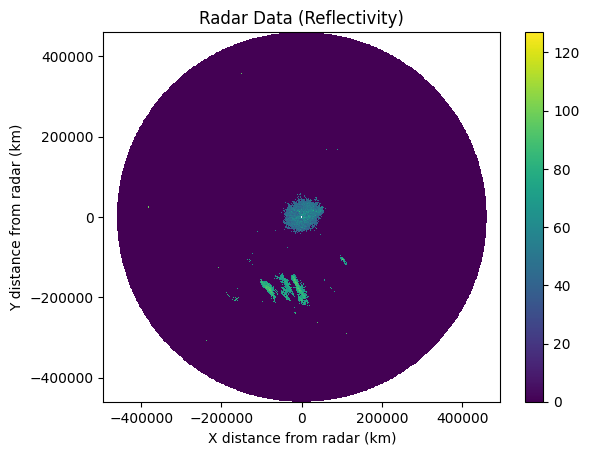

In [57]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

# sweep = 0
# ref_var = data.variables['Reflectivity_HI']
# ref_data = ref_var[sweep]
# rng = data.variables['distanceR_HI'][:]
# az = data.variables['azimuthR_HI'][sweep]

# Set the sweep number
sweep = 2

# Access the reflectivity data. The slicing is done directly on the variable.
ref_var = dataset['Reflectivity_HI']
ref_data = ref_var[sweep, :]  # Slicing is done directly, no 'array' attribute

# Access the range and azimuth data similarly.
rng_var = dataset['distanceR_HI']
az_var = dataset['azimuthR_HI']

rng = rng_var[:]  # This retrieves all data along this dimension
az = az_var[sweep, :]  # Data for a specific sweep

# Trigger the actual data download by converting to numpy arrays.
# The data attribute in Pydap's response object contains the actual data.
ref_data = np.array(ref_data.data)
rng = np.array(rng.data)
az = np.array(az.data)

az = np.squeeze(az)  # This reduces the shape from (1, 720) to (720,)
az_rad = np.deg2rad(az)  # Convert azimuth degrees to radians for the calculation

# Range data is usually one-dimensional, representing the distance of each bin from the radar.
# So, we expect `rng` not to change.

# We'll create 2D arrays representing the coordinates of each data point.
# We're "meshing" out a grid here where each point corresponds to an (r, azimuth) pair.
R, Az = np.meshgrid(rng, az_rad)  # This creates 2D grid arrays of range and azimuth

# Now, we convert from polar (r, θ) to Cartesian (x, y) coordinates.
X = R * np.cos(Az)  # Calculate X coordinates
Y = R * np.sin(Az)  # Calculate Y coordinates

# At this point, X and Y are 2D arrays representing the Cartesian coordinates of your radar data.
# `ref_data` contains the actual observation data. Its shape should match that of X and Y.
# If you wish to visualize this data, tools like matplotlib can help.

# For example, a simple contour plot representing the radar data could look like this:
import matplotlib.pyplot as plt

# We're assuming ref_data is 2D for this plot. If it's 3D (i.e., contains multiple sweeps),
# you should select one sweep: ref_data = ref_data[sweep_index]
ref_data_2d = np.squeeze(ref_data)  # If ref_data is (1, 720, 1832), this makes it (720, 1832)

plt.figure()
plt.pcolormesh(X, Y, ref_data_2d)  # This creates a 2D colored plot using Cartesian coordinates
plt.colorbar()  # Optionally add a colorbar to interpret the values
plt.title("Radar Data (Reflectivity)")
plt.xlabel("X distance from radar (km)")  # Assuming range is in kilometers
plt.ylabel("Y distance from radar (km)")
plt.axis('equal')  # Optional: This makes one unit on the X-axis equal one unit on the Y-axis.
plt.show()

In [39]:
import matplotlib
import warnings
from siphon.cdmr import Dataset
import os
import datetime
import numpy as np
from pydap.client import open_url
import matplotlib.pyplot as plt

%matplotlib inline

def convert_radial_velocity(raw_values, scale_factor=0.5, add_offset=-64.5):
    # Handling special values: You could choose to convert 'missing' or 'below threshold' indicators to NaN or some other indicator in this step.
    # Conversion to actual values
    raw_values = raw_values.astype(np.float32)
    raw_values[raw_values == 0] = np.nan
#     actual_values = (raw_values + add_offset) * scale_factor
    actual_values = (raw_values * scale_factor) + add_offset

    return actual_values

def convert_reflectivity(raw_values, scale_factor=0.5, add_offset=-33.0):
    # Convert special values to NaN or some other indicator as per your requirement.
    # For instance, you might treat 'missing_value' and 'signal_below_threshold' as NaN.
    raw_values = raw_values.astype(np.float32)  # Prevent overflow by ensuring the correct type
    raw_values[raw_values == 0] = np.nan  # Assuming 0 is used for missing or below threshold signals

    # Apply the scale and offset for actual reflectivity values
    actual_values = (raw_values * scale_factor) + add_offset
    return actual_values

def mean_reflectivity(refl_values):
    return np.mean(refl_values)


url = 'http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/'
from siphon.radarserver import RadarServer
rs = RadarServer(url)

tf = datetime.datetime.utcnow() - datetime.timedelta(days=2)
ti = tf - datetime.timedelta(hours=1) # Goes back up to 30 days

min_lat, max_lat, min_lon, max_lon = (33.25940115573943, 41.29581504940721, -123.18771739354659, -69.2910846403594)

query = rs.query()
query.lonlat_box(min_lon, max_lon, min_lat, max_lat).time_range(ti, tf)
cat = rs.get_catalog(query)

ds = list(cat.datasets.values())[0]
dataset_url = ds.access_urls['OPENDAP']
data = open_url(dataset_url)

rad_v = convert_radial_velocity(np.array(data['RadialVelocity_HI'][:])) # in proper meters per second
elev = np.array(data['elevationV_HI'][:])/180*np.pi # in radians
az = np.array(data['azimuthV_HI'][:])/180*np.pi # in radians
dist = np.array(data['distanceV_HI'][:]) # in meters
rad_v.shape, elev.shape, az.shape, dist.shape

((3, 720, 1192), (3, 720), (3, 720), (1192,))

In [40]:
xs = np.zeros(rad_v.shape)
ys = np.zeros(rad_v.shape)
zs = np.zeros(rad_v.shape)

for sweep in range(rad_v.shape[0]):
    rad_v_sweep = rad_v[sweep]
    elev_sweep = elev[sweep]
    az_sweep = az[sweep]
    
    for i in range(az_sweep.shape[0]):
        rad_v_i = rad_v_sweep[i]
        elev_i = elev_sweep[i]
        az_i = az_sweep[i]
        xs[sweep][i] = -rad_v_i*np.cos(elev_i)*np.sin(az_i)  # Eastward component
        ys[sweep][i] = -rad_v_i*np.cos(elev_i)*np.cos(az_i)  # Northward component
        zs[sweep][i] = -rad_v_i*np.sin(elev_i) # Upward component

xs_mean = np.mean(xs[~np.isnan(xs)])
ys_mean = np.mean(ys[~np.isnan(ys)])
zs_mean = np.mean(zs[~np.isnan(zs)])
np.array([xs_mean, ys_mean, zs_mean])

array([ 1.13613934, -2.15724139,  0.01692938])

In [41]:
xs = np.zeros(rad_v.shape)
ys = np.zeros(rad_v.shape)

x_pos = np.zeros(rad_v.shape)
y_pos = np.zeros(rad_v.shape)

for sweep in range(rad_v.shape[0]):
    rad_v_sweep = rad_v[sweep]
    elev_sweep = elev[sweep]
    az_sweep = az[sweep]
    for i in range(az_sweep.shape[0]):
        rad_v_i = rad_v_sweep[i]
        elev_i = elev_sweep[i]
        az_i = az_sweep[i]
        x_pos[sweep][i] = np.log(dist)*np.sin(az_i)
        y_pos[sweep][i] = np.log(dist)*np.cos(az_i)
        
        xs[sweep][i] = -rad_v_i*np.sin(az_i)*np.cos(elev_i)  # Eastward component
        ys[sweep][i] = -rad_v_i*np.cos(az_i)*np.cos(elev_i)  # Northward component


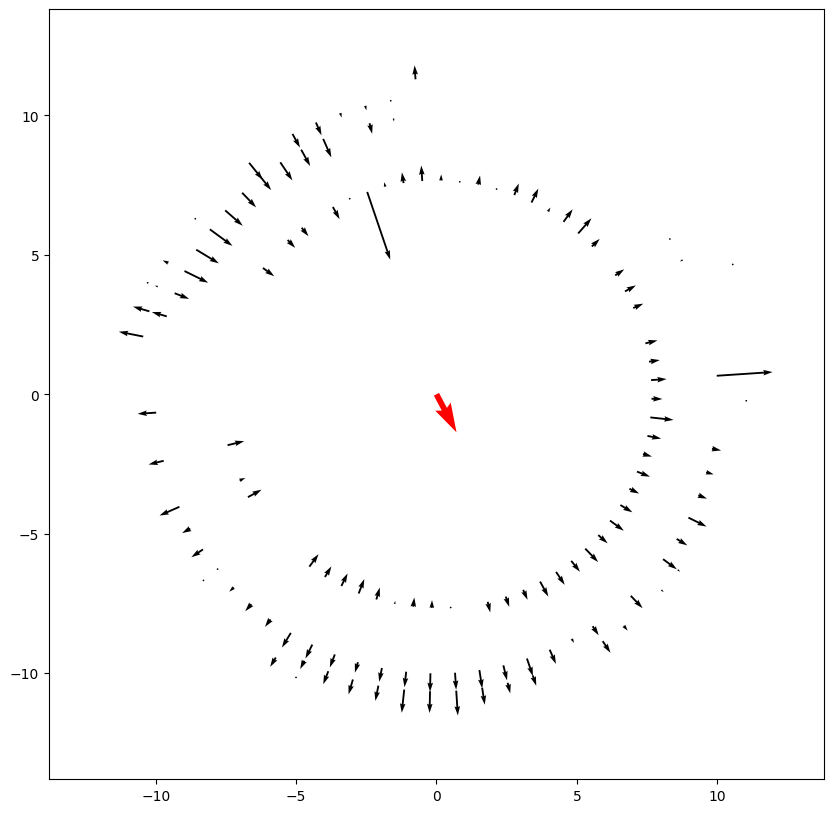

In [43]:
fig, ax = plt.subplots(figsize = [10, 10])

nan_mask = ~np.isnan(xs) & ~np.isnan(ys)
mags = np.sqrt(xs**2 + ys**2)
max_mag = np.max(mags[~np.isnan(mags)])
x = np.ravel(x_pos[1,::10,::80])
y = np.ravel(y_pos[1,::10,::80])
u = np.ravel(xs[1,::10,::80]/max_mag/100)
v = np.ravel(ys[1,::10,::80]/max_mag/100)
ax.quiver(x, y, u, v)
ax.quiver([0], [0], [xs_mean], [ys_mean], color = 'red', )
# ax.scatter(x, y, color = 'b')
# ax.set_xlim([-100000,100000])
# ax.set_ylim([-100000,100000])

fig.savefig('Single_Radar_Average_Wind_Speed.png')

## Getting data older thant 1 month

Website of datasets archive here: https://thredds-aws.unidata.ucar.edu/thredds/catalog/catalog.html

We can explore that website to get find the correct files containing the dataset we care about, and load it from there.

### Listing all radars available for a given date

In [277]:
# For a given date, get the list of possible radars:
import requests
from xml.etree import ElementTree
import datetime

date = datetime.datetime(2023, 1, 2) #Some example date

year = str(date.year).zfill(4)
month = str(date.month).zfill(2)
day = str(date.day).zfill(2)

# URL for the THREDDS catalog page you are interested in.
catalog_url = f'https://thredds-aws.unidata.ucar.edu/thredds/catalog/nexrad/level2/S3/{year}/{month}/{day}/catalog.xml'
radars = []
try:
    # Send a request to the server
    response = requests.get(catalog_url)
    response.raise_for_status()  # Check that request was successful

    # Parse the returned XML content
    tree = ElementTree.fromstring(response.content)

    # Define the namespace - this is used to correctly identify elements in the XML
    namespace = {'thredds': 'http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0'}

    # Find all catalogRef elements; these contain references to other catalogs or datasets
    catalog_refs = tree.findall('.//thredds:catalogRef', namespace)

    # Print dataset names (or other available metadata)
    for catalog_ref in catalog_refs:
        radars.append(catalog_ref.attrib['{http://www.w3.org/1999/xlink}title'])
        # You can also extract the URL path or other attributes if needed

except Exception as e:
    print(f"An error occurred when requesting radar data for {date.strftime('%Y-%m-%d')}:{e}")

print(f'{len(radars)} radars found!')



195 radars found!


In [278]:
# Neat function encompassing that ^

import requests
from xml.etree import ElementTree
import datetime
import time

def get_radar_list(date):
    """
    Fetch the list of radars for the given date.

    :param date: Date for which to fetch the radar list.
    :type date: datetime.datetime
    :return: List of radars available on the specified date.
    :rtype: list[str]
    """
    radars = []
    attempt_count = 0
    success = False

    while attempt_count < 3 and not success:
        try:
            # Format the date components
            year = str(date.year).zfill(4)
            month = str(date.month).zfill(2)
            day = str(date.day).zfill(2)

            # Construct the catalog URL
            catalog_url = f'https://thredds-aws.unidata.ucar.edu/thredds/catalog/nexrad/level2/S3/{year}/{month}/{day}/catalog.xml'

            # Send a request to the server
            response = requests.get(catalog_url)
            
            # If the response status code is not successful, an HTTPError will be raised
            response.raise_for_status()

            # Parse the returned XML content
            tree = ElementTree.fromstring(response.content)

            # Define the namespace
            namespace = {'thredds': 'http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0'}

            # Find all catalogRef elements
            catalog_refs = tree.findall('.//thredds:catalogRef', namespace)

            # Extract radar names
            for catalog_ref in catalog_refs:
                radars.append(catalog_ref.attrib['{http://www.w3.org/1999/xlink}title'])

            # If we reached this point, the data was successfully retrieved
            success = True

        except requests.RequestException as e:
            # This block will catch any Requests-related exceptions, such as network issues
            attempt_count += 1
            print(f"An error occurred when requesting radar data for {date.strftime('%Y-%m-%d')}:{e}")
            if attempt_count < 3:
                print("Trying again...")
                time.sleep(10)  # Sleep for 10 seconds before the next attempt

        except ElementTree.ParseError as e:
            # This block will handle any XML parsing errors
            attempt_count += 1
            print(f"An error occurred when requesting radar data for {date.strftime('%Y-%m-%d')}:{e}")
            if attempt_count < 3:
                print("Trying again...")
                time.sleep(10)  # Sleep for 10 seconds before the next attempt

        except Exception as e:
            # This will catch any other exceptions that could occur
            return f"An unexpected error occurred: {e}"

    if not success:
        return "Failed to retrieve data after multiple attempts."

    return radars

# Usage:
radars = get_radar_list(date)
print(f'{len(radars)} radars found!')


195 radars found!


### Listing all datasets available for a given date and a given radar

In [279]:
# Finding all available datasets in given date for given radar

radar = radars[0]

radar_catalog_url = f'https://thredds-aws.unidata.ucar.edu/thredds/catalog/nexrad/level2/S3/{year}/{month}/{day}/{radar}/catalog.xml'
datasets = []
try:
    # Send a request to the server
    response = requests.get(radar_catalog_url)
    response.raise_for_status()  # Check that request was successful

    # Parse the returned XML content
    tree = ElementTree.fromstring(response.content)

    # Define the namespace
    namespace = {'thredds': 'http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0'}

    # Find all dataset elements; these contain information about individual dataset files
    datasets_in_tree = tree.findall('.//thredds:dataset', namespace)

    # Collect and print information for each dataset
    for dataset in datasets_in_tree:
        if isinstance(dataset, ElementTree.Element):
            name = dataset.attrib.get('name')  # Using 'get' prevents a KeyError if 'name' doesn't exist

            # Ensure the name is a string and is not a path (does not contain '/')
            if isinstance(name, str) and '/' not in name:
                datasets.append(name)

except requests.exceptions.HTTPError as e:
    print(f"HTTP error occurred: {e}")
except Exception as e:
    print(f"An error occurred: {e}")
print(f'{len(datasets)} datasets found!')

290 datasets found!


In [280]:
import requests
from xml.etree import ElementTree
import datetime
import time

def get_datasets_for_radar(date, radar_name):
    """
    Retrieve the list of datasets for a given date and radar.

    :param date: Date for which to fetch the datasets.
    :type date: datetime.datetime
    :param radar_name: Name of the radar for which to fetch the datasets.
    :type radar_name: str
    :return: List of datasets available for the specified radar on the given date.
    :rtype: list[str]
    """
    datasets = []
    attempt_count = 0
    success = False

    while attempt_count < 3 and not success:
        try:
            # Format the date components
            year = str(date.year).zfill(4)
            month = str(date.month).zfill(2)
            day = str(date.day).zfill(2)

            # Construct the radar catalog URL
            radar_catalog_url = f'https://thredds-aws.unidata.ucar.edu/thredds/catalog/nexrad/level2/S3/{year}/{month}/{day}/{radar_name}/catalog.xml'

            # Send a request to the server
            response = requests.get(radar_catalog_url)
            response.raise_for_status()  # Check that request was successful

            # Parse the returned XML content
            tree = ElementTree.fromstring(response.content)

            # Define the namespace
            namespace = {'thredds': 'http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0'}

            # Find all dataset elements; these contain information about individual dataset files
            dataset_elements = tree.findall('.//thredds:dataset', namespace)

            # Collect dataset names, ensuring no duplicates are added
            for dataset in dataset_elements:
                if isinstance(dataset, ElementTree.Element):
                    name = dataset.attrib.get('name')  # Using 'get' prevents a KeyError if 'name' doesn't exist

                    # Ensure the name is a string and is not a path (does not contain '/')
                    if isinstance(name, str) and '/' not in name:
                        datasets.append(name)

            # If we reached this point, the data was successfully retrieved
            success = True

        except requests.RequestException as e:
            # This block will catch any Requests-related exceptions, such as network issues
            attempt_count += 1
            print(f"An error occurred when requesting radar data for {date.strftime('%Y-%m-%d')}:{e}")
            if attempt_count < 3:
                
                time.sleep(10)  # Sleep for 10 seconds before the next attempt

        except ElementTree.ParseError as e:
            # This block will handle any XML parsing errors
            attempt_count += 1
            print(f"An error occurred when requesting radar data for {date.strftime('%Y-%m-%d')}:{e}")
            if attempt_count < 3:
                time.sleep(10)  # Sleep for 10 seconds before the next attempt

        except Exception as e:
            # This will catch any other exceptions that could occur
            return f"An unexpected error occurred: {e}"

    if not success:
        return "Failed to retrieve data after multiple attempts."

    return datasets

# Usage:
datasets = get_datasets_for_radar(date, radar)

print(f'{len(datasets)} datasets found!')

290 datasets found!


### Loading radar and dataset information for a specific dataset

In [302]:
import requests
from bs4 import BeautifulSoup
import datetime

def my_eval(s):
    try:
        # Try to convert the string to a number (int or float)
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            try:
                # Try to convert the string to a datetime date
                return datetime.datetime.strptime(s, '%Y-%m-%d').date()
            except ValueError:
                # If all conversions fail, return the original string
                return s

url = "https://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3/2008/02/02/KABX/KABX20080202_000314.gz.html"
response = requests.get(url)

data_dict = {}

# Check if the request was successful
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all text areas in the webpage
    textareas = soup.find_all('textarea')
    
    for textarea in textareas:
        key = textarea['name'].replace('_attr','')
        value = textarea.get_text()
        data_dict[key] = value.strip()  # Using strip() to remove any leading/trailing whitespace

    for key in data_dict.keys():
        lines = data_dict[key].split('\n')
        data_dict[key] = {}
        for line in lines:
            attr = line.split(':')[0]
            val = line.split(':')[1][1:]
            data_dict[key][attr] = my_eval(val)
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

data_dict['Reflectivity']

{'_Unsigned': 'true',
 'units': 'dBz',
 'long_name': 'Reflectivity',
 'missing_value': '1, 0',
 'signal_below_threshold': 0,
 'scale_factor': 0.5,
 'add_offset': -33.0,
 'range_folding_threshold': 50,
 '_CoordinateAxes': 'timeR elevationR azimuthR distanceR'}

### Loading data for a specific dataset at a specific data from a specific radar

In [281]:
from pydap.client import open_url

dataset = datasets[0]

# Format:
# url = 'https://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3/[YYYY]/[MM]/[DD]/[RADAR]/[DATASET_FILE]'

dataset_url = f'https://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3/{year}/{month}/{day}/{radar}/{dataset}'

try:
    data = open_url(dataset_url)
except Exception as e:
    print(f"An error occurred when getting the dataset for {radar} radar {date.strftime('%Y-%m-%d')}: {e}")

data_dict = {}
#keys_of_interest = ['Reflectivity_HI', 'timeR_HI', 'elevationR_HI', 'azimuthR_HI', 'distanceR_HI', 'Reflectivity', 'timeR', 'elevationR', 'azimuthR', 'distanceR', 'RadialVelocity_HI', 'timeV_HI', 'elevationV_HI', 'azimuthV_HI', 'distanceV_HI', 'RadialVelocity', 'timeV', 'elevationV', 'azimuthV', 'distanceV']
for key in data.keys():
    data_dict[key] = np.array(data[key][:])
print([key for key in data_dict.keys()])

['Reflectivity_HI', 'timeR_HI', 'elevationR_HI', 'azimuthR_HI', 'distanceR_HI', 'numRadialsR_HI', 'numGatesR_HI', 'Reflectivity', 'timeR', 'elevationR', 'azimuthR', 'distanceR', 'numRadialsR', 'numGatesR', 'RadialVelocity_HI', 'timeV_HI', 'elevationV_HI', 'azimuthV_HI', 'distanceV_HI', 'numRadialsV_HI', 'numGatesV_HI', 'RadialVelocity', 'timeV', 'elevationV', 'azimuthV', 'distanceV', 'numRadialsV', 'numGatesV', 'SpectrumWidth_HI', 'SpectrumWidth', 'DifferentialReflectivity_HI', 'timeD_HI', 'elevationD_HI', 'azimuthD_HI', 'distanceD_HI', 'numRadialsD_HI', 'numGatesD_HI', 'DifferentialReflectivity', 'timeD', 'elevationD', 'azimuthD', 'distanceD', 'numRadialsD', 'numGatesD', 'CorrelationCoefficient_HI', 'timeC_HI', 'elevationC_HI', 'azimuthC_HI', 'distanceC_HI', 'numRadialsC_HI', 'numGatesC_HI', 'CorrelationCoefficient', 'timeC', 'elevationC', 'azimuthC', 'distanceC', 'numRadialsC', 'numGatesC', 'DifferentialPhase_HI', 'timeP_HI', 'elevationP_HI', 'azimuthP_HI', 'distanceP_HI', 'numRadial

In [192]:
# Neat function

from pydap.client import open_url
import numpy as np
import datetime

def fetch_radar_data(date, radar, dataset, convert_reflectivity, convert_radial_velocity, convert_data=True):
    """
    Fetch radar data for a specific date, radar, and dataset.

    The function connects to a data server, downloads radar data, and processes it.
    The processed data is returned as a dictionary. The function can handle
    connection issues and retries the download if necessary. If the dataset is not
    found, it attempts to find a gzip version.

    :param date: The date for the radar data, as a datetime object (e.g., datetime(2018, 1, 2)).
    :param radar: The radar identifier as a string (e.g., 'KTLX').
    :param dataset: The dataset identifier within the radar data (e.g., 'Level2_KTLX_20220116_0356.ar2v').
    :param convert_reflectivity: A function that converts reflectivity data.
    :param convert_radial_velocity: A function that converts radial velocity data.
    :return: A dictionary containing the radar data.

    URL format: 'https://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3/[YYYY]/[MM]/[DD]/[RADAR]/[DATASET_FILE]'
    """
    year = date.strftime('%Y')
    month = date.strftime('%m')
    day = date.strftime('%d')

    base_url = 'https://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3'
    dataset_url = f'{base_url}/{year}/{month}/{day}/{radar}/{dataset}'

    data_dict = {}
    keys_of_interest = ['Reflectivity_HI', 'timeR_HI', 'elevationR_HI', 'azimuthR_HI',
                        'distanceR_HI', 'Reflectivity', 'timeR', 'elevationR', 'azimuthR',
                        'distanceR', 'RadialVelocity_HI', 'timeV_HI', 'elevationV_HI',
                        'azimuthV_HI', 'distanceV_HI', 'RadialVelocity', 'timeV', 'elevationV',
                        'azimuthV', 'distanceV']

    try:
        data = open_url(dataset_url)
        # Process the data only if the connection was successful
        for key in data.keys():
            if convert_data:
                if key in keys_of_interest:
                    # Put all this in one single data convert function
                    data_dict[key] = np.array(data[key][:])
                    if 'Reflectivity' in key:
                        data_dict[key] = convert_reflectivity(data_dict[key])
                    elif 'RadialVelocity' in key:
                        data_dict[key] = convert_radial_velocity(data_dict[key])
                    elif 'elevation' in key or 'azimuth' in key:
                        data_dict[key] = data_dict[key]/180*np.pi
            else:
                data_dict[key] = np.array(data[key][:])
        return data_dict

    except Exception as initial_exception:
        try:
            print(f'Dataset {dataset} not found, trying {dataset}.gz')
            gzip_dataset_url = f'{dataset_url}.gz'
            data = open_url(dataset_url)
            # Process the data only if the connection was successful
            for key in data.keys():
                if convert_data:
                    if key in keys_of_interest:
                        # Put all this in one single data convert function
                        data_dict[key] = np.array(data[key][:])
                        if 'Reflectivity' in key:
                            data_dict[key] = convert_reflectivity(data_dict[key])
                        elif 'RadialVelocity' in key:
                            data_dict[key] = convert_radial_velocity(data_dict[key])
                        elif 'elevation' in key or 'azimuth' in key:
                            data_dict[key] = data_dict[key]/180*np.pi
                else:
                    data_dict[key] = np.array(data[key][:])
            return data_dict

        except Exception as gzip_exception:
            print(f"An error occurred when getting the dataset for {radar} radar on {date.strftime('%Y-%m-%d')}: {gzip_exception}")
            print(f"Initial exception: {initial_exception}")

            # Return an empty dict or None to signify that the process did not complete successfully
            return None

dataset = datasets[0]
data_dict = fetch_radar_data(date, radar, dataset, convert_reflectivity, convert_radial_velocity)
print([key for key in data_dict.keys()])

['Reflectivity_HI', 'timeR_HI', 'elevationR_HI', 'azimuthR_HI', 'distanceR_HI', 'Reflectivity', 'timeR', 'elevationR', 'azimuthR', 'distanceR', 'RadialVelocity_HI', 'timeV_HI', 'elevationV_HI', 'azimuthV_HI', 'distanceV_HI', 'RadialVelocity', 'timeV', 'elevationV', 'azimuthV', 'distanceV']


### Making example Radial Wind plot

(-5.447661876678467, 5.447661876678467)

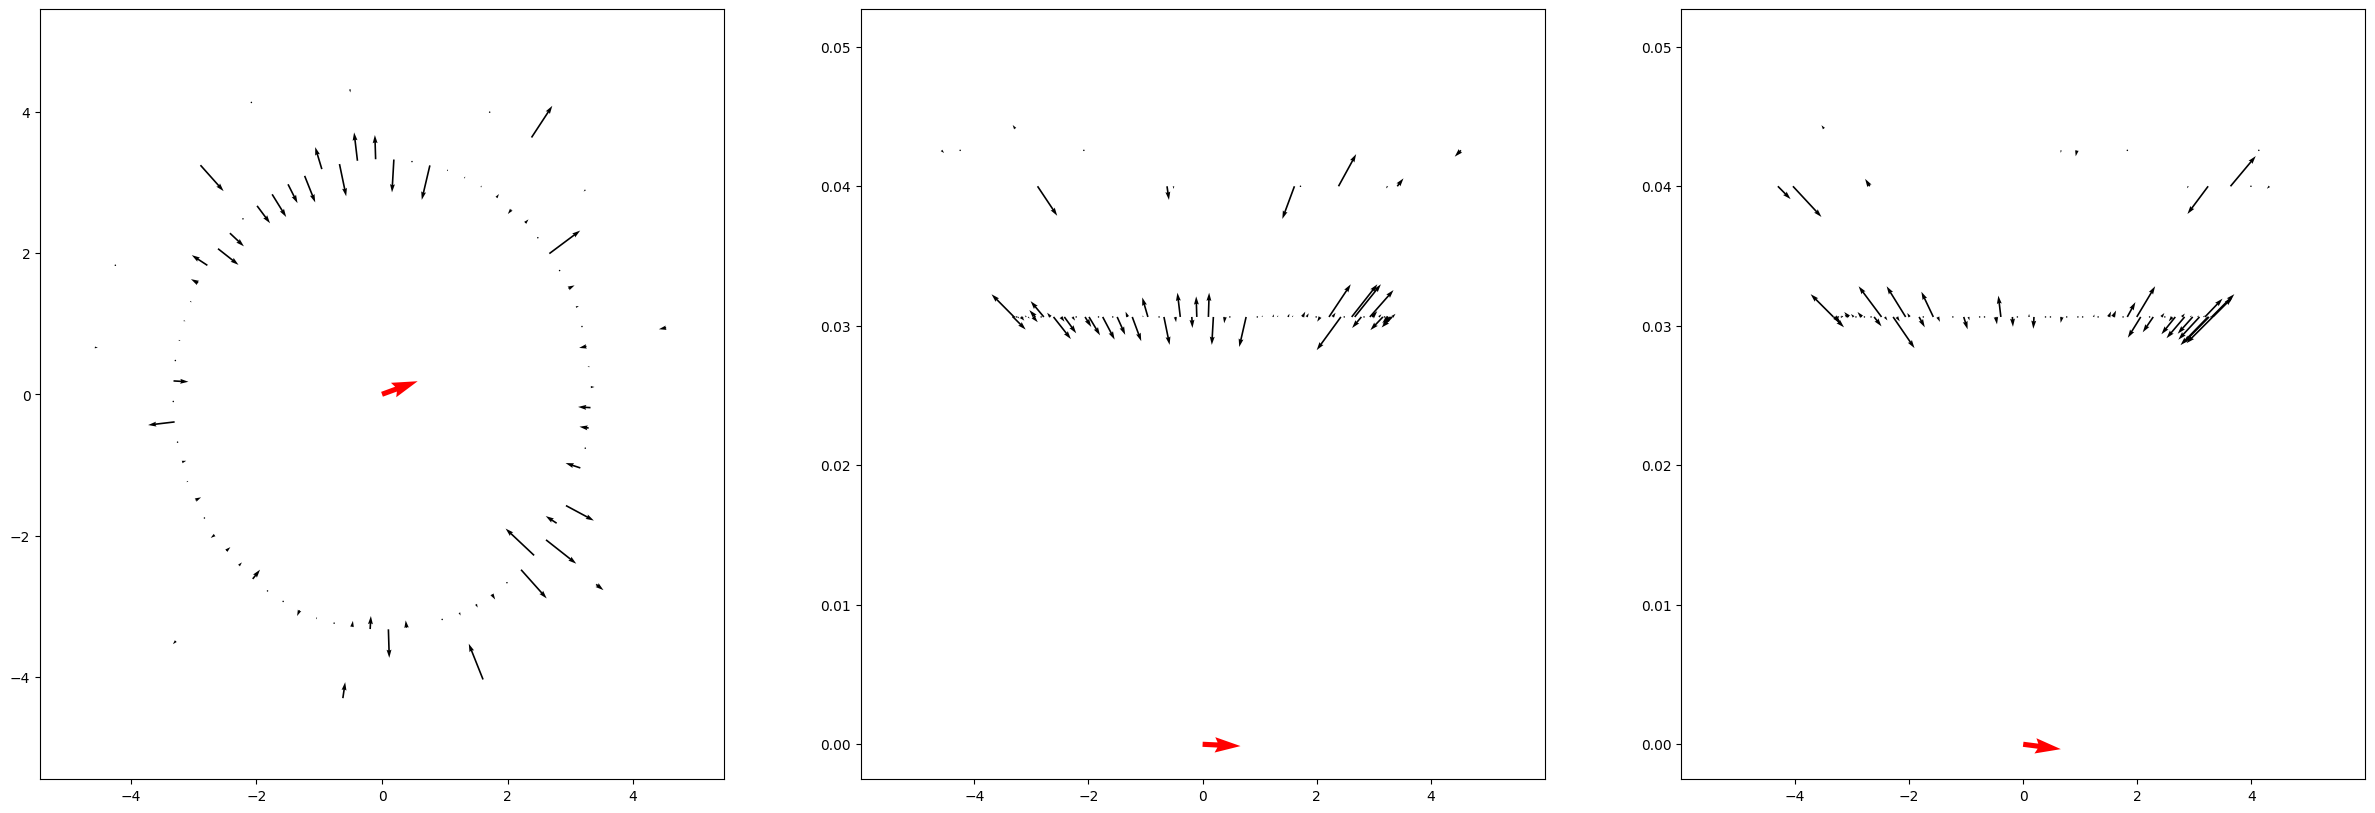

In [266]:
# Loading data info variables (simpler)
rad_v = data_dict['RadialVelocity_HI'] # in meters per second
elev = data_dict['elevationV_HI'] # in radians
az = data_dict['azimuthV_HI'] # in radians
dist = data_dict['distanceV_HI'] # in meters

# Variables to hold the x,y,z components of the radial wind vector
xs = np.zeros(rad_v.shape)
ys = np.zeros(rad_v.shape)
zs = np.zeros(rad_v.shape)
# Variables to hold the x,y,z components of the location each datapoint was gathered from
x_pts = np.zeros(rad_v.shape)
y_pts = np.zeros(rad_v.shape)
z_pts = np.zeros(rad_v.shape)

# Looping though each of the sweeps available in the dataset
for sweep in range(rad_v.shape[0]):
    rad_v_sweep = rad_v[sweep]
    elev_sweep = elev[sweep]
    az_sweep = az[sweep]
    # Looping through values of the azimuthal-elevation pairs
    for i in range(az_sweep.shape[0]):
        rad_v_i = rad_v_sweep[i]
        elev_i = elev_sweep[i]
        az_i = az_sweep[i]
        # Decomposing vectors into cartesian coordinates. negative sign to account for difference in pointing vector, and actual wind vector.
        # Need to make sure...
        xs[sweep][i] = -rad_v_i*np.cos(elev_i)*np.sin(az_i)  # Eastward component
        ys[sweep][i] = -rad_v_i*np.cos(elev_i)*np.cos(az_i)  # Northward component
        zs[sweep][i] = -rad_v_i*np.sin(elev_i) # Upward component
        
        x_pts[sweep][i] = np.log10(dist)*np.cos(elev_i)*np.sin(az_i)
        y_pts[sweep][i] = np.log10(dist)*np.cos(elev_i)*np.cos(az_i)
        z_pts[sweep][i] = np.log10(dist)*np.sin(elev_i)

# Calculating the mean wind vector
xs_mean = np.mean(xs[~np.isnan(xs)])
ys_mean = np.mean(ys[~np.isnan(ys)])
zs_mean = np.mean(zs[~np.isnan(zs)])

# Making 2D quiver plots for xy, xz and yz plane projections

fig, ax = plt.subplots(1, 3, figsize = [30, 10])

nan_mask = ~np.isnan(xs) & ~np.isnan(ys) & ~np.isnan(zs)

magnitudes = np.sqrt(xs**2 + ys**2 + zs**2)
max_mag = np.max(magnitudes[~np.isnan(magnitudes)])
norm = max_mag/100

#downsampling and downscaling
x = np.ravel(x_pts[0,::10,::80])
y = np.ravel(y_pts[0,::10,::80])
z = np.ravel(z_pts[0,::10,::80])

u = np.ravel(xs[0,::10,::80]/norm)
v = np.ravel(ys[0,::10,::80]/norm)
w = np.ravel(zs[0,::10,::80]/norm)

RANGE_X = np.max(x[~np.isnan(x)])
RANGE_Y = np.max(y[~np.isnan(y)])
RANGE_Z = np.max(z[~np.isnan(z)])

ax[0].quiver(x, y, u, v*RANGE_X/RANGE_Y)
ax[0].quiver([0], [0], [xs_mean], [ys_mean], color = 'red')

ax[1].quiver(x, z, u, w*RANGE_X/RANGE_Z)
ax[1].quiver([0], [0], [xs_mean], [zs_mean], color = 'red')

ax[2].quiver(y, z, v, w*RANGE_Y/RANGE_Z)
ax[2].quiver([0], [0], [ys_mean], [zs_mean], color = 'red')

ax[0].set_xlim([-RANGE,RANGE])
ax[0].set_ylim([-RANGE,RANGE])





# Web Scraping for station data

This is infuriating, but this is the best method I've found so far...
Only plus of the NEXRAD method is the fact it can measure verticaly, but the data is too complicated for it to be useful... This has wind speed and direction data for a LOT more stations, as well as humidity, temperature, etc. No radar data tho, but it's hourly

1. **station:** The identifier for the weather station, usually an alphanumeric code.
  
2. **valid:** The timestamp indicating when the observation was taken.

3. **lon:** Longitude of the weather station.

4. **lat:** Latitude of the weather station.

5. **tmpf:** Temperature in degrees Fahrenheit.

6. **dwpf:** Dew point temperature in degrees Fahrenheit.

7. **relh:** Relative humidity, typically given as a percentage.

8. **drct:** Wind direction in degrees, with 0° or 360° representing north.

9. **sknt:** Wind speed in knots.

10. **p01i:** Precipitation for the past 1 hour, usually in inches.

11. **alti:** Altimeter setting, which is the current pressure at sea level.

12. **mslp:** Mean Sea Level Pressure.

13. **vsby:** Visibility, typically in statute miles.

14. **gust:** Wind gust speed in knots.

15. **skyc1, skyc2, skyc3, skyc4:** Sky cover for up to four levels. This can be in terms of clear (CLR), scattered (SCT), broken (BKN), overcast (OVC), etc.

16. **skyl1, skyl2, skyl3, skyl4:** Altitude (usually in feet) at which the respective sky cover (skyc1-4) levels are observed.

17. **wxcodes:** Weather codes representing specific weather phenomena, like rain (RA), snow (SN), etc.

18. **ice_accretion_1hr:** Amount of ice accretion (ice buildup) in the past 1 hour.

19. **ice_accretion_3hr:** Amount of ice accretion in the past 3 hours.

20. **ice_accretion_6hr:** Amount of ice accretion in the past 6 hours.

21. **peak_wind_gust:** Peak wind gust observed during the period.

22. **peak_wind_drct:** Direction from which the peak wind gust came.

23. **peak_wind_time:** Time when the peak wind gust was observed.

24. **feel:** "Feels like" temperature, which takes into account factors like wind chill or heat index.

25. **metar:** METAR is a format for reporting weather information, mainly used by pilots. This column would contain the raw METAR string for the observation.

26. **snowdepth:** Depth of snow on the ground, typically measured in inches.


In [69]:
# Fetching temperature and other stuff
# https://github.com/akrherz/iem/blob/main/scripts/asos/iem_scraper_example.py
import datetime
from urllib.request import urlopen
import json
import pandas as pd

def my_eval(s):
    try:
        # Try to convert the string to a number (int or float)
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            try:
                # Try to convert the string to a datetime date
                return datetime.datetime.strptime(s, '%Y-%m-%d').date()
            except ValueError:
                # If all conversions fail, return the original string
                return s

def text_to_dataframe(data):
    data_values = {}
    for line in data.split('\n'):
        if not line.startswith('#') and len(line) > 0:
            if len(data_values) == 0:
                data_values = {col:[] for col in line.split(',')}
            else:
                line_data = line.split(',')
                for i, col in enumerate(data_values.keys()):
                    data_values[col] += [line_data[i]]
    return pd.DataFrame(data_values)

startts = datetime.datetime(2023, 1, 1)
endts = datetime.datetime(2023, 1, 2)

SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"
service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

station_ids = []
stations = []
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY"""
networks = []
for state in states.split():
    networks.append(f"{state}_ASOS")

for network in networks:
    # Get metadata
    uri = (
        "https://mesonet.agron.iastate.edu/"
        f"geojson/network/{network}.geojson"
    )
    data = urlopen(uri)
    stations += json.load(data)["features"]
print(f'{len(stations)} stations found!')

2843 stations found!


In [42]:
from IPython.display import clear_output

valid_stations = []

columns_of_interest = ['station', 'valid', 'lon', 'lat', 'tmpf',
                    'relh', 'drct', 'sknt', 'p01i', 'skyc1', 'skyc2',
                    'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4',
                    'wxcodes', 'ice_accretion_1hr']

all_data = None
for i, station in enumerate(stations):
    clear_output(wait=True)
    print(f'{i} / {len(stations)} | Valid: {len(valid_stations)} / {i}')
    station_id = station["properties"]["sid"]
    uri = f"{service}&station={station_id}"

    data = urlopen(uri, timeout=300).read().decode("utf-8")
    number_of_data_lines = sum(1 for line in data.split('\n') if not line.startswith('#'))

    if number_of_data_lines > 2:
        valid_stations.append(station_id)
        if all_data is None:
            all_data = text_to_dataframe(data)[columns_of_interest]
        else:
            all_data = pd.concat([all_data, text_to_dataframe(data)[columns_of_interest]], ignore_index=True)
all_data.index = range(len(all_data))
print(f'{len(valid_stations)} valid stations found!')

2842 / 2843 | Valid: 2399 / 2842
2400 valid stations found!


In [196]:
from cdo_api_py import Client
import pandas as pd
import datetime
from pprint import pprint
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import clear_output

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors
# Package to generate plot images
from src.frontend import plotter

from scipy.spatial import distance_matrix

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

def gaussian_interpolation(df, lon, lat, quantity, p=2):
    """
    Interpolate using Inverse Distance Weighting

    Parameters:
    - df: DataFrame with 'lon', 'lat', and 'PREC' columns
    - lon, lat: coordinates of the point to interpolate
    - p: power parameter for IDW

    Returns:
    - Interpolated value at (lon, lat)
    """
    df_temp = df.dropna(subset=quantity)
    # Calculate the distance matrix
    target = np.array([[lon, lat]])
    points = df_temp[['lon', 'lat']].values
    distances = distance_matrix(target, points).ravel()
    min_d = np.min(distances)
    max_d = np.max(distances)
    distances = (distances - min_d)/(max_d - min_d)
    p = p/(max_d - min_d)
    # Compute weights
    weights = np.exp(-distances**2/(2*p**2))
    weights /= weights.sum()

    # Compute interpolated value
    interpolated_value = np.dot(weights, df_temp[quantity].values)
    
    return interpolated_value

gaussian_interpolation(all_data[['lon', 'lat', 'tmpf']].dropna(),
                       40.30090194568993, -99.29223933380611,
                       'tmpf')

# min_lat, max_lat, min_lon, max_lon = (33.25940115573943, 41.29581504940721, -123.18771739354659, -69.2910846403594)

lons = np.linspace(min_lon, max_lon, 100)
lats = np.linspace(min_lat, max_lat, 25)
# # ts = np.linspace(all_data['timestamp'].min(), all_data['timestamp'].max(), 24)
# t = utils.to_unix_timestamp(startts + datetime.timedelta(hours=1))

LATS, LONS = np.meshgrid(lats, lons)

lats_grid = np.ravel(LATS)
lons_grid = np.ravel(LONS)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
for i in range(1, 23):
    try:
        clear_output(wait=True)
        print(f'{i} / 23')
        t = 1672531200 + i*3600

        data_T = all_data[abs(all_data['timestamp']-t) <= 3600/2]
        data_T = data_T[['lon', 'lat', 'timestamp', 'tmpf']].dropna()
        temps = [gaussian_interpolation(data_T, lon, lat, 'tmpf', p=0.2) for lon, lat in zip(lons_grid, lats_grid)]

        TEMPS = np.reshape(temps, LATS.shape)

        data_directory = '../data/flight/KJFK_KLAX/'
        # From here we load the config file
        with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
            try:
                config = yaml.safe_load(file)
            except yaml.YAMLError as exc:
                print(exc)

        compressor = compressors.CsvCompressor(config)

        state_vector_file = os.path.join(data_directory, 'state_vectors', '758525_1673250271_1673269782_KJFK_KLAX.csv')

        df = compressor.decode_to_dataframe_from_file(state_vector_file)

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                                       figsize=[10, 10])
        pltr = plotter.Plotter(config)

        ax.pcolormesh(LONS, LATS, TEMPS)

        pltr.plot_route(state_vector_file, compressor, ax = ax)

        fig.savefig(f'TAVG_{str(i).zfill(2)}.png')
        plt.close()
    except:
        print("Error")

22 / 23


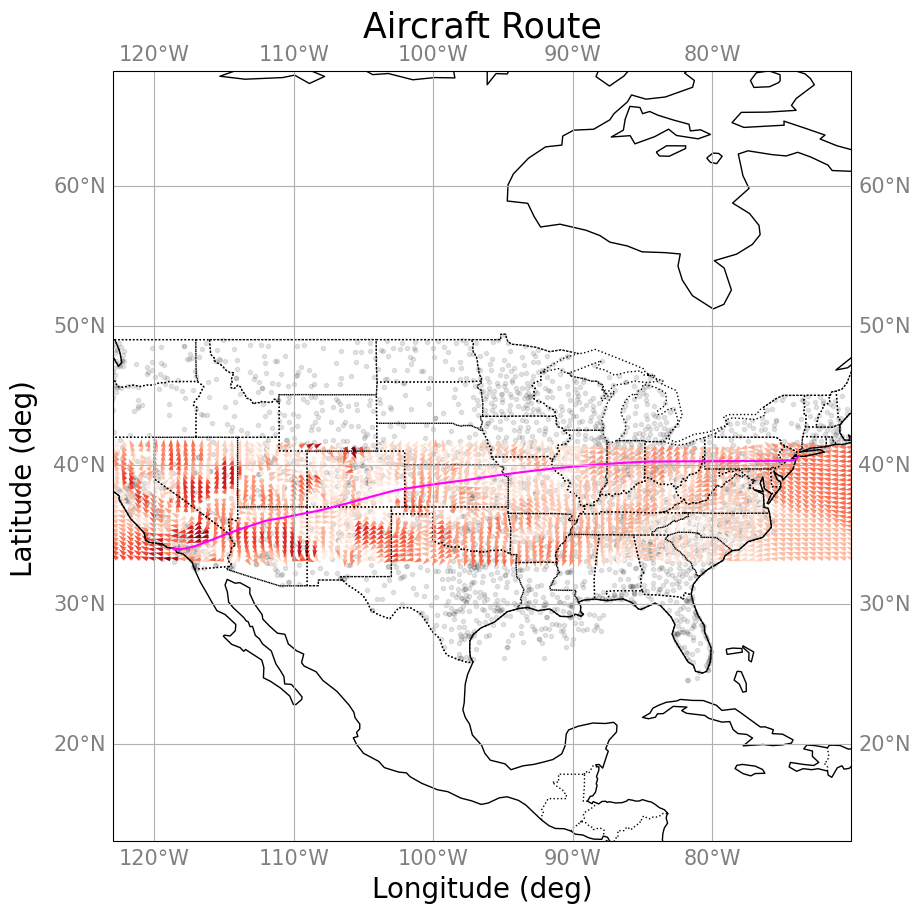

In [240]:
t = 1672574062.8385003 + 5*3600

data_T = all_data[abs(all_data['timestamp']-t) <= 3600/2]
data_T = data_T[['lon', 'lat', 'timestamp', 'wind_E', 'wind_N']].dropna()
wind_e = np.array([gaussian_interpolation(data_T, lon, lat, 'wind_E', p=0.2) for lon, lat in zip(lons_grid, lats_grid)])
wind_n = np.array([gaussian_interpolation(data_T, lon, lat, 'wind_N', p=0.2) for lon, lat in zip(lons_grid, lats_grid)])

WIND_E = np.reshape(wind_e, LATS.shape)
WIND_N = np.reshape(wind_n, LATS.shape)

data_directory = '../data/flight/KJFK_KLAX/'
# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

compressor = compressors.CsvCompressor(config)

state_vector_file = os.path.join(data_directory, 'state_vectors', '758525_1673250271_1673269782_KJFK_KLAX.csv')

df = compressor.decode_to_dataframe_from_file(state_vector_file)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                               figsize=[10, 10])
pltr = plotter.Plotter(config)

ax.scatter(stations_lons, stations_lats, marker='.', color='k', alpha=0.1)

mags = np.sqrt(wind_e**2 + wind_n**2)
mags_norm = (mags - np.min(mags))/(np.max(mags) - np.min(mags))
colors = plt.cm.Reds(mags_norm)
ax.quiver(lons_grid, lats_grid, wind_e/mags, wind_n/mags, color = colors)
# ax.pcolormesh(LONS, LATS, WIND_E)

pltr.plot_route(state_vector_file, compressor, ax = ax)

stations_lons = [station['geometry']['coordinates'][0] for station in stations]
stations_lats = [station['geometry']['coordinates'][1] for station in stations]



In [209]:
for i in range(1, 23):
    try:
        clear_output(wait=True)
        print(f'{i} / 23')
        t = 1672531200 + i*3600

        data_T = all_data[abs(all_data['timestamp']-t) <= 3600/2]
        data_T = data_T[['lon', 'lat', 'timestamp', 'wind_E', 'wind_N']].dropna()
        wind_e = np.array([gaussian_interpolation(data_T, lon, lat, 'wind_E', p=0.2) for lon, lat in zip(lons_grid, lats_grid)])
        wind_n = np.array([gaussian_interpolation(data_T, lon, lat, 'wind_N', p=0.2) for lon, lat in zip(lons_grid, lats_grid)])

        WIND_E = np.reshape(wind_e, LATS.shape)
        WIND_N = np.reshape(wind_n, LATS.shape)

        data_directory = '../data/flight/KJFK_KLAX/'
        # From here we load the config file
        with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
            try:
                config = yaml.safe_load(file)
            except yaml.YAMLError as exc:
                print(exc)

        compressor = compressors.CsvCompressor(config)

        state_vector_file = os.path.join(data_directory, 'state_vectors', '758525_1673250271_1673269782_KJFK_KLAX.csv')

        df = compressor.decode_to_dataframe_from_file(state_vector_file)

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                                       figsize=[10, 10])
        pltr = plotter.Plotter(config)

        mags = np.sqrt(wind_e**2 + wind_n**2)
        mags_norm = (mags - np.min(mags))/(np.max(mags) - np.min(mags))
        colors = plt.cm.Reds(mags_norm)
        ax.quiver(lons_grid, lats_grid, wind_e/mags, wind_n/mags, color = colors)
        # ax.pcolormesh(LONS, LATS, WIND_E)

        pltr.plot_route(state_vector_file, compressor, ax = ax)
        fig.savefig(f'WIND_{str(i).zfill(2)}.png')
        plt.close()
    except:
        print("Error")

22 / 23


In [234]:
stations_lons = station['geometry']['coordinates'][0]
stations_lats = station['geometry']['coordinates'][1]

In [4]:
import pandas as pd
from io import StringIO

with open('../data/flight/GlobalAirportDatabase/GlobalAirportDatabase.txt', 'r') as f:
    lines = f.read()
df = pd.read_csv(StringIO(lines), sep=":", header=None)
df.columns = ['ICAO', 'ShortCode', 'Name', 'City', 'Country', 'LatDeg', 'LatMin', 'LatSec', 'LatDir', 'LonDeg', 'LonMin', 'LonSec', 'LonDir', 'Altitude', 'lat', 'lon']

df.to_csv('../data/flight/airport_database.csv')

In [6]:
"apple".capitalize()

'Apple'

In [ ]:
capitalize